In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA 
from sklearn.svm import LinearSVC

In [2]:
df = pd.read_csv('crypto.csv', index_col='timestamp')
print(df.head())
n_row, n_col = df.shape
print(f'There are {n_row} rows and {n_col} columns')

                       amount   price  coin
timestamp                                  
2018-08-15 18:49:25  0.233800  529.41     1
2018-08-15 18:50:32  0.982765  529.45     1
2018-08-15 18:50:33  0.017235  529.45     1
2018-08-15 18:50:33  0.017235  529.46     1
2018-08-15 18:50:34  0.965530  529.45     1
There are 1314830 rows and 3 columns


Let's add a new column calculating the amount of cryptocurrency purchased with the daily price and call the new column Value.

In [3]:
df['value'] = df.amount * df.price
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1314830 entries, 2018-08-15 18:49:25 to 2018-09-22 10:07:01
Data columns (total 4 columns):
amount    1314830 non-null float64
price     1314830 non-null float64
coin      1314830 non-null int64
value     1314830 non-null float64
dtypes: float64(3), int64(1)
memory usage: 50.2+ MB


If we want to change the coin labels from 1,2,3,4,5 to their respective names, we can use the .apply() method and lambda functions over the coin column. But First we'll need to change the column type to 

In [4]:
# Lamda function using replace
df['coin'] = df.coin.astype(str)
df['coin'] =df.coin.apply(lambda x: x.replace('1', 'Bitcoin Cash'))
df['coin'] =df.coin.apply(lambda x: x.replace('2', 'Bitcoin'))
df['coin'] =df.coin.apply(lambda x: x.replace('3', 'Ethereum'))
df['coin'] =df.coin.apply(lambda x: x.replace('4', 'Litecoin'))
df['coin'] =df.coin.apply(lambda x: x.replace('5', 'Ripple'))
assert df.coin.dtypes == np.object
print(df.tail())

                          amount    price    coin        value
timestamp                                                     
2018-09-22 10:06:34    95.389900  0.58073  Ripple    55.395777
2018-09-22 10:06:34   253.735000  0.58072  Ripple   147.348989
2018-09-22 10:06:35  2150.875100  0.58000  Ripple  1247.507558
2018-09-22 10:06:50  5133.932400  0.58201  Ripple  2987.999996
2018-09-22 10:07:01   222.319377  0.58326  Ripple   129.670000


In [5]:
print(df.describe())
print(df['coin'].value_counts(dropna=False))
print(df['price'].describe())

             amount         price         value
count  1.314830e+06  1.314830e+06  1.314830e+06
mean   5.372889e+02  3.130907e+03  1.588603e+03
std    4.234103e+03  3.215822e+03  6.956488e+03
min    1.000000e-08  2.530000e-01  2.557900e-09
25%    3.194035e-02  6.047000e+01  2.411842e+01
50%    3.300000e-01  4.715600e+02  2.030175e+02
75%    6.495622e+00  6.462340e+03  1.018026e+03
max    8.995980e+05  7.411850e+03  1.764929e+06
Bitcoin         607607
Ethereum        290479
Ripple          270182
Litecoin         74137
Bitcoin Cash     72425
Name: coin, dtype: int64
count    1.314830e+06
mean     3.130907e+03
std      3.215822e+03
min      2.530000e-01
25%      6.047000e+01
50%      4.715600e+02
75%      6.462340e+03
max      7.411850e+03
Name: price, dtype: float64


There are barely any counts near the max value, so we may want to investigate this further for outliers. 

In [6]:
print(df.isnull().sum())
print(df.notnull())

amount    0
price     0
coin      0
value     0
dtype: int64
                     amount  price  coin  value
timestamp                                      
2018-08-15 18:49:25    True   True  True   True
2018-08-15 18:50:32    True   True  True   True
2018-08-15 18:50:33    True   True  True   True
2018-08-15 18:50:33    True   True  True   True
2018-08-15 18:50:34    True   True  True   True
2018-08-15 18:50:34    True   True  True   True
2018-08-15 18:55:21    True   True  True   True
2018-08-15 18:55:29    True   True  True   True
2018-08-15 18:55:37    True   True  True   True
2018-08-15 18:55:37    True   True  True   True
2018-08-15 18:56:24    True   True  True   True
2018-08-15 19:00:00    True   True  True   True
2018-08-15 19:00:01    True   True  True   True
2018-08-15 19:00:57    True   True  True   True
2018-08-15 19:07:31    True   True  True   True
2018-08-15 19:07:34    True   True  True   True
2018-08-15 19:08:48    True   True  True   True
2018-08-15 19:08:50    True

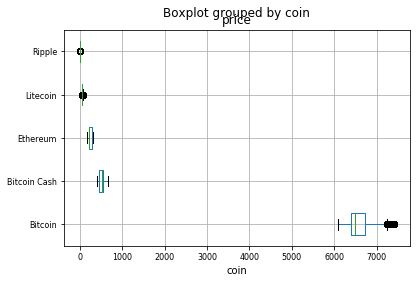

In [7]:
df.boxplot(column='price', by='coin', vert=False, fontsize=8)
plt.show()

From the boxplot, we can see some outliers for Bitcoin. Given the volatile fluctuations in Bitcoin's price history, these outliers could ve valid data points. Again, further investigation is needed to determine whether or not to drop any of those points. 

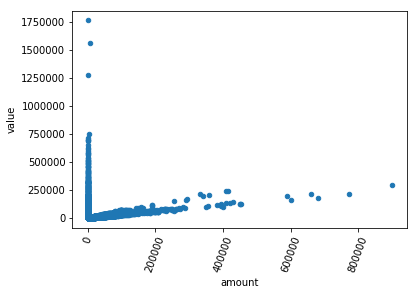

In [8]:
df.plot(kind='scatter', x='amount', y='value', rot=70)
plt.show()

With the cryptocurrencies listed in an untidy format, let's use .pivot_table() method to create a new column for each unique value ("price") in a specified column ("type of coin"). We will also need to use .reset_index() to get back the original DataFrame after being pivoted. 

In [9]:
df = df.pivot_table(index=['timestamp'], columns='coin', values='price', aggfunc='last')
df = df.reset_index()
print(df.head())
print(f'There are {n_row} rows and {n_col} columns')

coin            timestamp  Bitcoin  Bitcoin Cash  Ethereum  Litecoin   Ripple
0     2018-08-15 18:45:56      NaN           NaN    297.56       NaN      NaN
1     2018-08-15 18:46:15   6548.0           NaN       NaN       NaN      NaN
2     2018-08-15 18:46:24   6548.0           NaN       NaN       NaN      NaN
3     2018-08-15 18:46:38   6547.3           NaN       NaN       NaN      NaN
4     2018-08-15 18:46:41      NaN           NaN       NaN       NaN  0.29083
There are 1314830 rows and 3 columns


Our group decided to use the last non-NaN value instance to fill in missing values as it most accurately resembles the flow of time series data. Later we will impute any missing values using the mean() or mode() to determine which method results in more accurate analyses.

In [10]:
#fill missing values with next instance since some initial values are missing

df['Bitcoin Cash'] = df['Bitcoin Cash'].fillna(method='bfill')
df['Bitcoin'] = df['Bitcoin'].fillna(method='bfill')
df['Ethereum'] = df['Ethereum'].fillna(method='bfill')
df['Litecoin'] = df['Litecoin'].fillna(method='bfill')
df['Ripple'] = df['Ripple'].fillna(method='bfill')


In [11]:
print(df.dtypes)

coin
timestamp        object
Bitcoin         float64
Bitcoin Cash    float64
Ethereum        float64
Litecoin        float64
Ripple          float64
dtype: object


Before delving into any further analysis, let's modify the 'timestamp' column to reflect datetime64 instead of it's current object type. This will allow for more interesting time series analysis.

In [12]:

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the timestamp column as the dataframe index
df = df.set_index(['timestamp'])


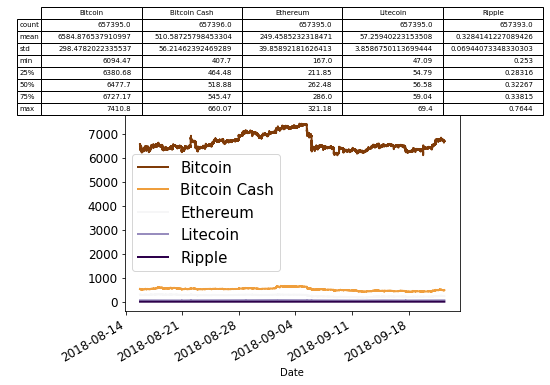

In [13]:
ax = df.plot(colormap='PuOr',linewidth=2,fontsize=12)

# Additional customizations
ax.set_xlabel('Date')
ax.legend(fontsize=15)

df_summary = df.describe()
# Add summary statistics to plot
ax.table(cellText=df_summary.values, 
         colWidths=[0.3]*len(df.columns), 
         rowLabels=df_summary.index, 
         colLabels=df_summary.columns,
         fontsize=15,
         loc='top')

# Show plot
plt.show()

In [14]:
print(df.head())

coin                 Bitcoin  Bitcoin Cash  Ethereum  Litecoin   Ripple
timestamp                                                              
2018-08-15 18:45:56   6548.0        529.41    297.56     58.04  0.29083
2018-08-15 18:46:15   6548.0        529.41    297.81     58.04  0.29083
2018-08-15 18:46:24   6548.0        529.41    297.81     58.04  0.29083
2018-08-15 18:46:38   6547.3        529.41    297.81     58.04  0.29083
2018-08-15 18:46:41   6547.3        529.41    297.81     58.04  0.29083


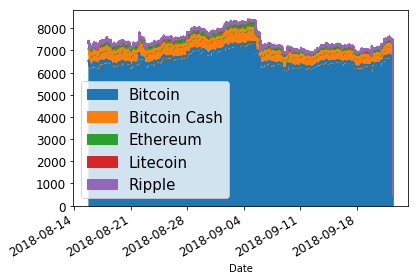

In [15]:
ax = df.plot.area(fontsize=12)

# Additional customizations
ax.set_xlabel('Date')
ax.legend(fontsize=15)

# Show plot
plt.show()

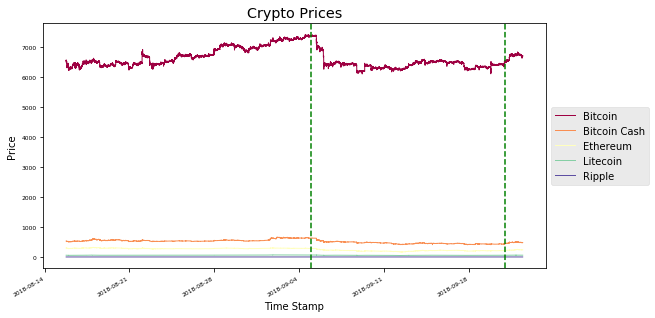

In [16]:
ax = df.plot(figsize=(9,5), linewidth=1, fontsize=6, colormap='Spectral')
ax.set_xlabel('Time Stamp')
ax.set_ylabel('Price')

#highlight the time periods where prices dipped denoted by dashed green vertical lines
ax.axvline('2018-09-04 23:5:56', color='green', linestyle='--')
ax.axvline('2018-09-21', color='green', linestyle='--')

plt.style.use('ggplot')
ax.set_title('Crypto Prices')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Right now, it is hard to discern the data trends for any other currency besides Bitcoin. So, let's create subplots for each coin to imporove clairty and provide more context.

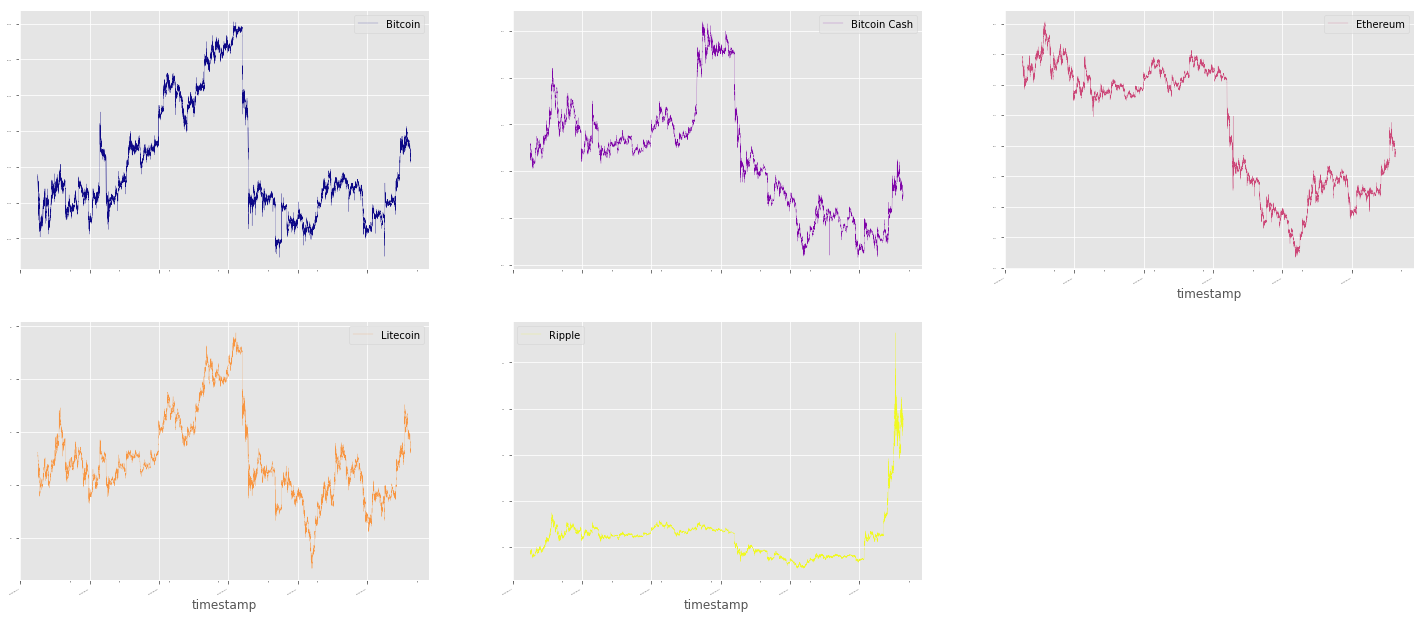

In [17]:
df.plot(subplots=True, 
          layout= (3,3), 
          sharex=True, 
          sharey=False, 
          colormap='plasma', 
          fontsize=2, 
          legend=True, 
          linewidth=0.2,
          figsize=(25,18))

plt.show()

We can observe that for most of the coins, around 09-04-2018 (~middle of x-axis) the prices all similarly dropped.

Not that we can view the visualizations for each individual coin, we want to determine if and how the coins are correlated with one another. Here, we'll be computing the correlation coeffcients using pearson and spearman, depending on whether the relationships are thought to be linear or not.

coin           Bitcoin  Bitcoin Cash
coin                                
Bitcoin       1.000000      0.656415
Bitcoin Cash  0.656415      1.000000
The correlation between Bitcoin and Bitcoin Cash is 0.656418 

coin                 Bitcoin
timestamp                   
2018-08-15 18:45:56  6548.00
2018-08-15 18:46:15  6548.00
2018-08-15 18:46:24  6548.00
2018-08-15 18:46:38  6547.30
2018-08-15 18:46:41  6547.30
2018-08-15 18:46:42  6547.30
2018-08-15 18:46:44  6547.30
2018-08-15 18:46:45  6550.96
2018-08-15 18:46:51  6547.42
2018-08-15 18:46:58  6547.42
2018-08-15 18:46:59  6547.42
2018-08-15 18:47:00  6555.00
2018-08-15 18:47:04  6547.18
2018-08-15 18:47:05  6554.57
2018-08-15 18:47:06  6552.92
2018-08-15 18:47:07  6552.92
2018-08-15 18:47:11  6552.92
2018-08-15 18:47:12  6552.92
2018-08-15 18:47:19  6552.92
2018-08-15 18:47:23  6552.92
2018-08-15 18:47:30  6552.92
2018-08-15 18:47:33  6552.92
2018-08-15 18:47:34  6548.65
2018-08-15 18:47:35  6548.65
2018-08-15 18:47:37  6548.65
2018-0

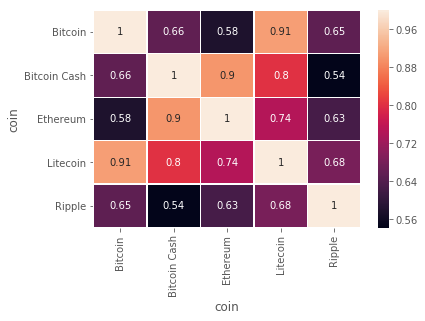

In [18]:
print(df[['Bitcoin', 'Bitcoin Cash']].corr(method='spearman'))
print("The correlation between Bitcoin and Bitcoin Cash is 0.656418",'\n')
print(df[['Bitcoin']])

corr_df = df.corr(method='spearman')

#create heatmap of correlation matrix
sns.heatmap(corr_df,
           annot=True,
           linewidths=0.4,
           annot_kws={"size": 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

Here we see using the Spearman method, though not necessarily ordinal values, we can use this method to rank each coin and correlation coefficients, which can then be used to summarise the monotonic (entirely nonincreasing or nondecreasing) strength and direction of the relationships. Next, we will use the Pearson correlation method to determine the linear strength and direction between the variables. Comparing the Pearson graph below with the produced Spearman Graph, we can denote anytime S > P, we have a correlation that is monotonic but not linear. 

Let's now visualize the correlation matrix using the pearson method.

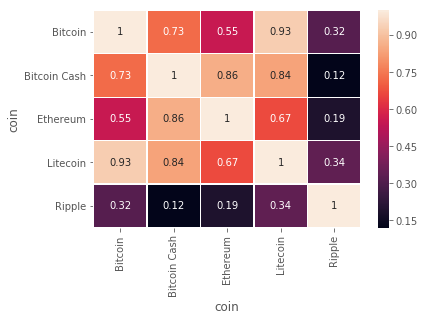

In [19]:
corr_df = df.corr(method='pearson')

#create heatmap of correlation matrix
sns.heatmap(corr_df,
           annot=True,
           linewidths=0.4,
           annot_kws={"size": 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

Let's also visualize a clustermap using the pearson method.

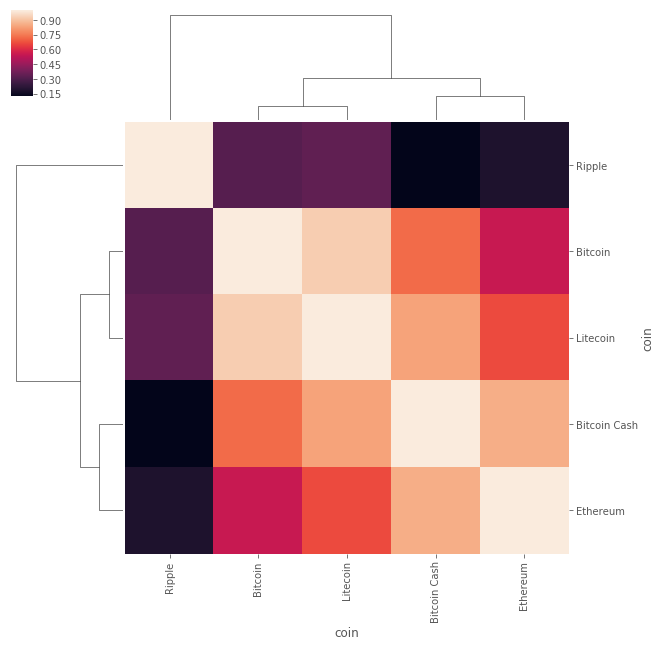

In [20]:
corr_df = df.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(10, 10))

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [21]:
df = df.dropna()
print(df.isnull().sum())
print(df.notnull())

coin
Bitcoin         0
Bitcoin Cash    0
Ethereum        0
Litecoin        0
Ripple          0
dtype: int64
coin                 Bitcoin  Bitcoin Cash  Ethereum  Litecoin  Ripple
timestamp                                                             
2018-08-15 18:45:56     True          True      True      True    True
2018-08-15 18:46:15     True          True      True      True    True
2018-08-15 18:46:24     True          True      True      True    True
2018-08-15 18:46:38     True          True      True      True    True
2018-08-15 18:46:41     True          True      True      True    True
2018-08-15 18:46:42     True          True      True      True    True
2018-08-15 18:46:44     True          True      True      True    True
2018-08-15 18:46:45     True          True      True      True    True
2018-08-15 18:46:51     True          True      True      True    True
2018-08-15 18:46:58     True          True      True      True    True
2018-08-15 18:46:59     True          Tr

Time series decomposition is a great way to reveal the time series structure. Let's obtain the seasonal decomposition and visual the components

In [22]:
# import seasonal_decompose() function from statsmodels library
import statsmodels.api as sm


# Initialize dictionary
coin_decomp = {}

# Get the names of each time series in the DataFrame
coin_names = df.columns

# Run time series decomposition on each time series of the DataFrame
for ts in coin_names:
    ts_decomposition = sm.tsa.seasonal_decompose(df[ts].values, freq=10)
    coin_decomp[ts] = ts_decomposition


    

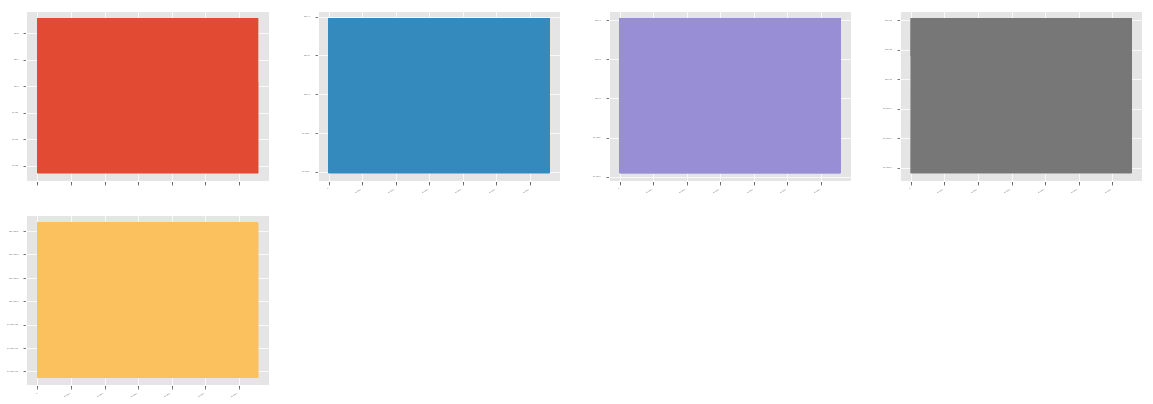

In [23]:
# Extract the seasonal values for the decomposition of each time series
coin_seasonal = {}
for ts in coin_names:
    coin_seasonal[ts] = coin_decomp[ts].seasonal
    
# Create a DataFrame from the jobs_seasonal dictionary
seasonality_df = pd.DataFrame.from_dict(coin_seasonal)

# Remove the label for the index
seasonality_df.index.name = None

# Create a faceted plot of the seasonality_df DataFrame
seasonality_df.plot(subplots=True,
                   layout=(4,4),
                   sharey=False,
                   fontsize=2,
                   linewidth=0.3,
                   legend=False,
                   figsize=(20,16))

# Show plot
plt.show()

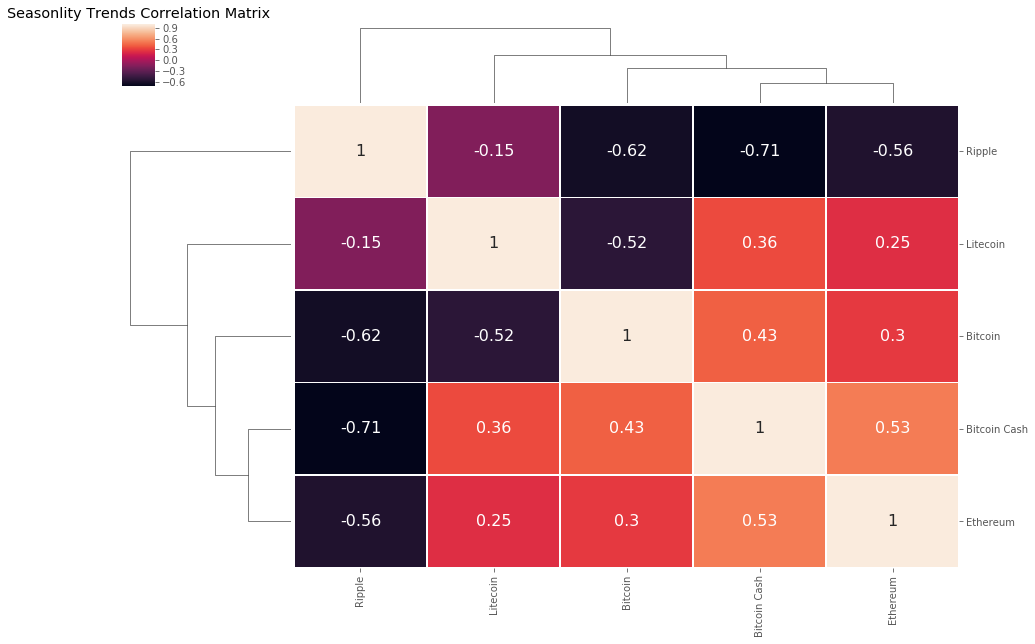

In [24]:
# Get correlation matrix of the seasonality_df DataFrame
seasonality_corr = seasonality_df.corr(method='spearman')

# Customize the clustermap of the seasonality_corr correlation matrix
fig = sns.clustermap(seasonality_corr, annot=True, annot_kws={"size": 16},linewidths=.4, figsize=(15, 10))
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.title('Seasonlity Trends Correlation Matrix')
plt.show()


From the Correlation Matrix above, we can say Ripple is negatively correlated with Bitcoin Cash (-.71), Ripple has some positive correlation with Ethereum (0.58), and there does not seem to be any correlation between Bitcoin with Litecoin (-0.1), Bitcoin with Ethereum (-0.061), and Bitcoin with Ripple (-0.42).

Taking a closer look at just the Bitcoin trend, let's highlight the steep drop occuring at 2018-09-04.

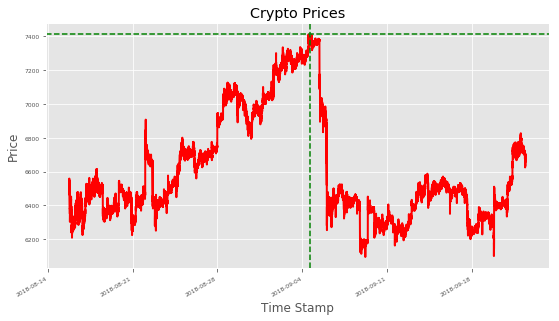

In [25]:
ax = df['Bitcoin'].plot(color='red', figsize=(9,5), linewidth=2, fontsize=6)
ax.set_xlabel('Time Stamp')
ax.set_ylabel('Price')
plt.style.use('ggplot')
ax.set_title('Crypto Prices')
ax.axvline('2018-09-04 14:45:56', color='green', linestyle='--')
ax.axhline(7410.8, color='green',linestyle='--')
plt.show()




Looking at the summary statistics and the graph above, we can see the max value for Bitcoin was 7410.80 occurring on 2018-09-04, before the price dropped a low of 6094.47.

In [26]:
print(df.describe())

coin         Bitcoin   Bitcoin Cash       Ethereum       Litecoin  \
count  657393.000000  657393.000000  657393.000000  657393.000000   
mean     6584.876185     510.587407     249.458560      57.259398   
std       298.478588      56.214709      39.858977       3.858680   
min      6094.470000     407.700000     167.000000      47.090000   
25%      6380.680000     464.480000     211.850000      54.790000   
50%      6477.700000     518.880000     262.480000      56.580000   
75%      6727.170000     545.470000     286.000000      59.040000   
max      7410.800000     660.070000     321.180000      69.400000   

coin          Ripple  
count  657393.000000  
mean        0.328414  
std         0.069441  
min         0.253000  
25%         0.283160  
50%         0.322670  
75%         0.338150  
max         0.764400  


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 657393 entries, 2018-08-15 18:45:56 to 2018-09-22 10:07:01
Data columns (total 5 columns):
Bitcoin         657393 non-null float64
Bitcoin Cash    657393 non-null float64
Ethereum        657393 non-null float64
Litecoin        657393 non-null float64
Ripple          657393 non-null float64
dtypes: float64(5)
memory usage: 30.1 MB
None


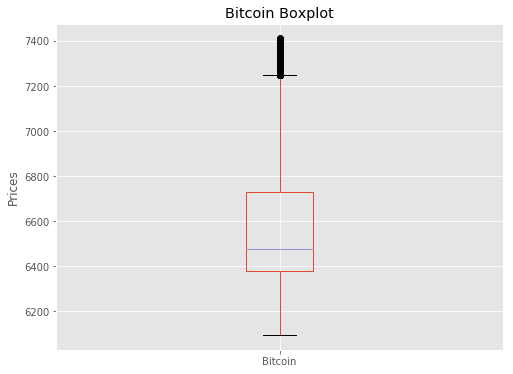

In [27]:

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
df.boxplot(column='Bitcoin', ax=ax)
# frame['ArrDelay'].plot.box(ax=ax) # Alternative
ax.set_title('Bitcoin Boxplot')
ax.set_xlabel('')
ax.set_ylabel('Prices')
print(df.info())

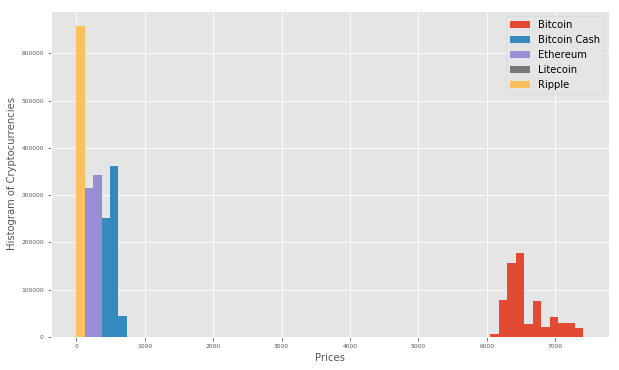

In [28]:
ax = df.plot(kind='hist', bins=60, fontsize=6, figsize=(10,6))
ax.set_xlabel('Prices', fontsize=10)
ax.set_ylabel('Histogram of Cryptocurrencies', fontsize=10)
plt.legend(fontsize=10)
plt.show()


Again, to better visualize just the Bitcoin data, let's look at a density plot.

In [29]:
# ax = df['Bitcoin'].plot(kind='density', linewidth=4, fontsize=6, figsize=(10,6))
# ax.set_xlabel('Prices', fontsize=10)
# ax.set_ylabel('Density plot for Bitcoin', fontsize=10)
# plt.show()

In [30]:
# import matplotlib.pyplot as plt

# plt.style.use('fivethirtyeight')
# from statsmodels.graphics import tsaplots

# # Display autocorrelation plot s
# fig = tsaplots.plot_acf(df['Bitcoin'], lags=1)

# # Show plot
# plt.show()

With autocorrelation values close to 0, we can conclude values between consecutive observations are not correlated with one another. 

What if we wanted to be able to predict the future price of the coins based on our data and past trends? We would first need to split our data into train-test splits so we can test the quality of our model fit. 

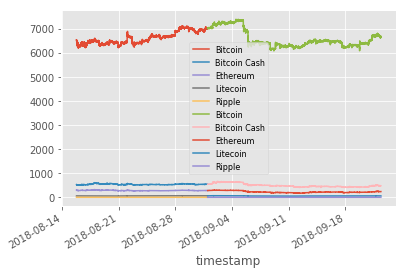

In [31]:
coin_train = df.loc[:'2018-08']
coin_test = df.loc['2018-09':]
fig, ax = plt.subplots()

#Plot train and test sets 
coin_train.plot(ax=ax)
coin_test.plot(ax=ax)
plt.legend(fontsize=8)
plt.show()

In order to statistically test whether the null hypothesis is our time series data is non-stationary due to trend, we can implement the augmented Dicky-Fuller test (this can be imported in Python as adfuller). If we can decide the data is non-stationary, then we will have to transform it into a stationary set prior to making our predictions. This can often be done by transforming the data by taking the differece, log, square root, or proportional change. We will certainly look to find the simplest solution as to not complicate our results. This time, let's switch over to Litecoin column of the dataset to determine if its stationary (p-value < 0.05 significance) and see if . (Due to the data size, running the dicky-fuller test on all rows causes a idle kernel). If we wanted a p-value of 0.05 or below, the test statistic (ADF Statisitic) needs to be below the 5% (or -2.8615 below) critical value of the test statistic. 

In [32]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(df['Litecoin'],2) #maxlag set to 1


# Print p-value
print('p-value:', result[1])

# Print critical values
print('critical values', result[4]) 

# Print the test statistic 
print('ADF Statistic:', result[0])



p-value: 0.15553459506823403
critical values {'1%': -3.4303599474064623, '5%': -2.8615443966388914, '10%': -2.5667723401698734}
ADF Statistic: -2.3526970834847987


Next, we'll take the difference meaning from each value in our time series we subtract the previous value by using the .diff() method. The results below show the impact on our p-value as it drops to 0.0 or below 0.05 and the ADF statistic becomes more negative, stabilizing our data to a more stationary stance for future modeling. 

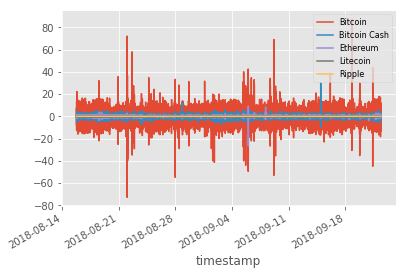

ADF Statistic: -496.5446663969251
p-value: 0.0
critical values {'1%': -3.4303599474215942, '5%': -2.8615443966455794, '10%': -2.566772340173433}
ADF Statistic: -496.5446663969251


In [33]:
# Calculate the difference of the time series
df_stationary = df.diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(df_stationary['Litecoin'],2)

# Plot the differenced time series
fig, ax = plt.subplots()
df_stationary.plot(ax=ax)
plt.legend(fontsize=8)
plt.show()


# Print the test statistic and the p-value
print('ADF Statistic:', result[0])

# Print p-value
print('p-value:', result[1])

# Print critical values
print('critical values', result[4]) 

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])


In [34]:
# # Calculate the second difference of the time series
# df_stationary = df.diff().diff().dropna()

# # Run ADF test on the differenced time series
# result = adfuller(df_stationary['Litecoin'],2)

# # Plot the differenced time series
# fig, ax = plt.subplots()
# df_stationary.plot(ax=ax)
# plt.legend(fontsize=8)
# plt.show()


# # Print the test statistic and the p-value
# print('ADF Statistic:', result[0])

# # Print p-value
# print('p-value:', result[1])

# # Print critical values
# print('critical values', result[4]) 

# # Print the test statistic and the p-value
# print('ADF Statistic:', result[0])

An alternate method popular for stock price data is log transform.  

In [35]:
# # Calculate the first difference and drop the nans
# df_diff = df.diff().dropna()

# # Run test and print
# result_diff = adfuller(df['Litecoin'],2)
# print(result_diff)

# # Calculate log-return and drop nans
# df_log = np.log((df/df.shift(1)).dropna())

# # Run test and print
# result_log = adfuller(df_log['Litecoin'],2)
# print('p-value:', result_log[1])
# print(result_log)

# fig, ax = plt.subplots()
# df_log.plot(ax=ax)
# plt.legend(fontsize=8)
# plt.show()

In [36]:
print(df.describe())
print(df.head())

coin         Bitcoin   Bitcoin Cash       Ethereum       Litecoin  \
count  657393.000000  657393.000000  657393.000000  657393.000000   
mean     6584.876185     510.587407     249.458560      57.259398   
std       298.478588      56.214709      39.858977       3.858680   
min      6094.470000     407.700000     167.000000      47.090000   
25%      6380.680000     464.480000     211.850000      54.790000   
50%      6477.700000     518.880000     262.480000      56.580000   
75%      6727.170000     545.470000     286.000000      59.040000   
max      7410.800000     660.070000     321.180000      69.400000   

coin          Ripple  
count  657393.000000  
mean        0.328414  
std         0.069441  
min         0.253000  
25%         0.283160  
50%         0.322670  
75%         0.338150  
max         0.764400  
coin                 Bitcoin  Bitcoin Cash  Ethereum  Litecoin   Ripple
timestamp                                                              
2018-08-15 18:45:56   6548.

In [37]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.arima_model import ARMA

# # Create ARIMA(2,1,2) model
# arima = SARIMAX(df, order=(2,1,2))

# # Fit ARIMA model
# arima_results = arima.fit()

# # Make ARIMA forecast of next 10 values
# arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# # Print forecast
# print(arima_value_forecast)


# # # Generate predictions
# # one_step_forecast = df['Bitcoin'].get_prediction(start=-30, dynamic=True)

# # # Extract prediction mean
# # mean_forecast = one_step_forecast.predicted_mean

# # # Get confidence intervals of predictions
# # confidence_intervals = one_step_forecast.conf_int()

# # # Select lower and upper confidence limits
# # lower_limits = confidence_intervals.loc[:,'lower close']
# # upper_limits = confidence_intervals.loc[:,'upper close']

# # # Print best estimate predictions
# # print(mean_forecast)

As we are predicting a continuous output value, this is a regression problem.

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_pacf(df['Bitcoin'], lags=24)
plt.show()

In [ ]:
index_month = df.index.month

# Compute the mean number of passengers for each month of the year
mean_airline_by_month = df['Bitcoin'].groupby(index_month).mean()

# Plot the mean number of passengers for each month of the year
mean_airline_by_month.plot()
plt.legend(fontsize=20)
plt.show()

In [ ]:
# num_cols = ['Bitcoin']
# df = pd.DataFrame(columns=num_cols)
# ma = df.rolling(window=52).mean()
# mstd = df.rolling(window=52).std()
# ma['upper'] = ma + (mstd * 2) 
# ma['lower'] = ma - (mstd * 2) 
# ax = ma.plot(linewidth=0.8, fontsize=6, figsize=(10,5))
# ax.set_xlabel('Date', fontsize=10)
# ax.set_ylabel('Bitcoin Prices', fontsize=10)
# ax.set_title('Rolling mean and variance of Bitcoin Prices', fontsize=10)
# plt.show()
# print(ma)


Let's check for outliers using the 5th and 95th percentiles for simplicity and determine if outliers are affecting the data. We'll accomplish this by first removing the 'Time Stamp' and 'Coin' columns since we want to only deal with integer columns. Then we'll compute the percentiles and then filter values based on our computed percentiles by using .apply() method. 

In [ ]:
# # remove timestamp columns as it is not type int
# filter_df = df.loc[:,df.columns != 'timestamp']

#Now let's compute the percentiles
low = 0.05
high = 0.95
quant_df = filter_df.quantile([low,high])
print(quant_df)

# filter values based on printed limits
filter_df = filter_df.apply(lambda x: x[(x>=quant_df.loc[low,x.name]) & 
                                    (x <= quant_df.loc[high,x.name])], axis=0)


# # reintroduce 'timestamp' column to complete datafram
# filter_df = pd.concat([df.loc[:,'timestamp'], filter_df], axis=1)

#drop any Nan values
filter_df.dropna(inplace=True)

print(filter_df.tail())
df = filter_df
print(df.tail())

In [ ]:
# bcash_mean = df['Bitcoin Cash'].mean()
# bc_mean = df['Bitcoin'].mean()
# ethereum_mean = df['Ethereum'].mean()
# lcoin_mean = df['Litecoin'].mean()
# r_mean = df['Ripple'].mean()

# df['Bitcoin Cash'] = df['Bitcoin Cash'].fillna(bcash_mean)
# df['Bitcoin'] = df['Bitcoin'].fillna(bc_mean)
# df['Ethereum'] = df['Ethereum'].fillna(ethereum_mean)
# df['Litecoin'] = df['Litecoin'].fillna(lcoin_mean)
# df['Ripple'] = df['Ripple'].fillna(r_mean)

# print(df.describe())